In [2]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e, hbar

Using MPI version 3.1, 1 processes


# Just a random test with code from the wiki

In [2]:
import meep as mp
import math

def refl_planar(theta, kz_2d):
    resolution = 100

    dpml = 1.0
    sx = 10
    sx = 10 + 2*dpml
    cell_size = mp.Vector3(sx)
    pml_layers = [mp.PML(dpml)]

    fcen = 1.0

    # plane of incidence is XZ
    k = mp.Vector3(z=math.sin(theta)).scale(fcen)

    sources = [mp.Source(mp.GaussianSource(fcen,fwidth=0.2*fcen),
                         component=mp.Ey,
                         center=mp.Vector3(-0.5*sx+dpml))]

    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        k_point=k,
                        kz_2d=kz_2d,
                        resolution=resolution)

    refl_fr = mp.FluxRegion(center=mp.Vector3(-0.25*sx))
    refl = sim.add_flux(fcen, 0, 1, refl_fr)

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, mp.Vector3(-0.5*sx+dpml), 1e-9))

    input_flux = mp.get_fluxes(refl)
    input_data = sim.get_flux_data(refl)
    sim.reset_meep()

    # add a block with n=3.5 for the air-dielectric interface
    geometry = [mp.Block(size=mp.Vector3(0.5*sx,mp.inf,mp.inf),
                         center=mp.Vector3(0.25*sx),
                         material=mp.Medium(index=3.5))]

    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        boundary_layers=pml_layers,
                        sources=sources,
                        k_point=k,
                        kz_2d=kz_2d,
                        resolution=resolution)

    refl = sim.add_flux(fcen, 0, 1, refl_fr)
    sim.load_minus_flux_data(refl, input_data)

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, mp.Vector3(-0.5*sx+dpml), 1e-9))

    refl_flux = mp.get_fluxes(refl)
    freqs = mp.get_flux_freqs(refl)

    Rmeep = -refl_flux[0]/input_flux[0]
    return Rmeep


# rotation angle of source: CCW around Y axis, 0 degrees along +X axis
theta_r = math.radians(19.4)

Rmeep_real_imag = refl_planar(theta_r,"real/imag")
Rmeep_complex = refl_planar(theta_r,"complex")
Rmeep_3d = refl_planar(theta_r,"3d")

n1=1
n2=3.5

# compute angle of refracted planewave in medium n2
# for incident planewave in medium n1 at angle theta_in
theta_out = lambda theta_in: math.asin(n1*math.sin(theta_in)/n2)

# compute Fresnel reflectance for S-polarization in medium n2
# for incident planewave in medium n1 at angle theta_in
Rfresnel = lambda theta_in: math.fabs((n2*math.cos(theta_out(theta_in))-n1*math.cos(theta_in))/(n2*math.cos(theta_out(theta_in))+n1*math.cos(theta_in)))**2

print("refl:, {} (real/imag), {} (complex), {} (3d), {} (analytic)".format(Rmeep_real_imag,Rmeep_complex,Rmeep_3d,Rfresnel(theta_r)))


-----------
Initializing structure...
time for choose_chunkdivision = 7.1205e-05 s
Working in 2D dimensions.
Computational cell is 12 x 0.01 x 0 with resolution 100
time for set_epsilon = 0.00236686 s
-----------
field decay(t = 50.005): 0.281209936106544 / 0.281209936106544 = 1.0
field decay(t = 100.01): 4.921056335336712e-13 / 0.281209936106544 = 1.7499581997245777e-12
run 0 finished at t = 100.01 (20002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000116841 s
Working in 2D dimensions.
Computational cell is 12 x 0.01 x 0 with resolution 100
     block, center = (3,0,0)
          size (6,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.00379237 s
-----------
field decay(t = 50.005): 0.3193543783025269 / 0.3193543783025269 = 1.0
field decay(t = 100.01): 1.670959985971505e-05 / 0.3193543783025269 = 5.232306489277538e-05
field decay(t = 150.015000000000

# Example 1 : simple waveguide \[[source](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#fields-in-a-waveguide)\]
## Setting up and running the simulation
### My takeaway : 

You create in this order : 

- `cell` is a `mp.Vector3` specifying the 3 dims of that parallelepipedic cell
- geometry is a list of `Block` objects / other geometry things
- then you add sources (carful to put the `center`, ie it origin of the source, not too close to boundaries to avoid boundary effects)
- absorbing boundary conditions are done by `mp.PML` (perfectly matched layers)
- we then define the grid using `resolution` = number of pixels per distance unit. 

> In general, at least 8 pixels/wavelength in the highest dielectric is a good idea [source](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#fields-in-a-waveguide)

- <span style='color:red'>we package all of that in a `Simulation` object.</span>
- we run the simulation by calling `Simualtion.run(until=$time)`


In [3]:
cell = mp.Vector3(16,8,0)

def eps_func(r):
    return (6.5 +5.5*np.sin(r.x)) if abs(r.y) <=0.5 else 1

#geometry = [mp.Block(mp.Vector3(mp.inf,1,mp.inf),
#                     center=mp.Vector3(),
#                     material=mp.Medium(epsilon_func = eps_func))]

sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                     component=mp.Ez,
                     center=mp.Vector3(-7,0))]

pml_layers = [mp.PML(1.0)]
resolution = 10

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    epsilon_func = eps_func,
                    sources=sources,
                    resolution=resolution)


In [4]:
sim.run(until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 7.6183e-05 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
time for set_epsilon = 0.0380469 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (4000 timesteps)


## Plotting the fields

### My takeaway : 

- just use `matplotlib` lol
- the function to call is `sim.get_array(center, size, component)`
- then you can just do a good ole `plt.imshow` (don't forget to transpose the data)

### Plotting the system

/home/mechanicalpenguin/Documents/quandela-project/lib64/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mechanicalpenguin/Documents/quandela-project/lib64/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


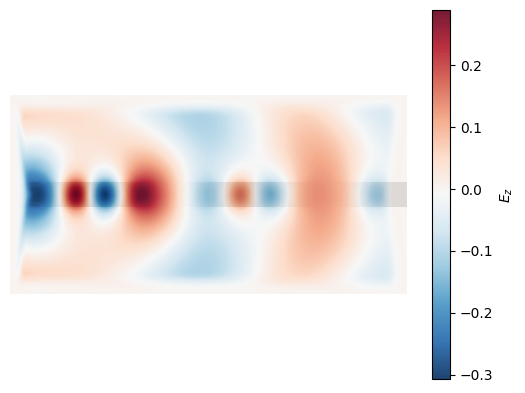

In [5]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)

plt.figure()
plt.imshow(eps_data.transpose(), interpolation='none', cmap='binary', vmin = 1)
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu_r', alpha=0.9)
plt.axis('off')
plt.colorbar(label = r'$E_z$')
plt.show()


## Other examples

### Bent waveguide

In [6]:
# simulation properties

cell = mp.Vector3(16,16,0)
geometry = [mp.Block(mp.Vector3(12,1,mp.inf),    # note : we have two blocks that overlap !
                     center=mp.Vector3(-2.5,-3.5),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(1,12,mp.inf),
                     center=mp.Vector3(3.5,2),
                     material=mp.Medium(epsilon=12))]
pml_layers = [mp.PML(1.0)]
resolution = 10

# sources

sources = [mp.Source(mp.ContinuousSource(wavelength=2*(11**0.5), width=20),
                     component=mp.Ez,
                     center=mp.Vector3(-7,-3.5),
                     size=mp.Vector3(0,1))]

# setting up simulation 

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

sim.run(mp.at_beginning(mp.output_epsilon),  # only output epsilon at the first time step by wrapping the `mp.output_epsilon` call inside `mp.at_beginning`
        mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)), # output Ez every 0.6 timestep in the same way
        until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 7.8388e-05 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0329726 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

creating output file "./eps-000000.00.h5"...
creating output file "./ez.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 8.0191e-05 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.028187 s
-----------
Meep: using output directory '-out'


FloatProgress(value=0.0, description='0% done ', max=200.0)

creating output file "-out/eps-000000.00.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


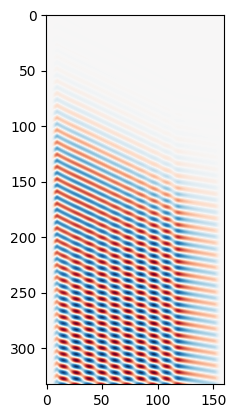

In [7]:
# simulation properties

cell = mp.Vector3(16,16,0)
geometry = [mp.Block(mp.Vector3(12,1,mp.inf),    # note : we have two blocks that overlap !
                     center=mp.Vector3(-2.5,-3.5),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(1,12,mp.inf),
                     center=mp.Vector3(3.5,2),
                     material=mp.Medium(epsilon=12))]
pml_layers = [mp.PML(1.0)]
resolution = 10

# sources

sources = [mp.Source(mp.ContinuousSource(wavelength=2*(11**0.5), width=20),
                     component=mp.Ez,
                     center=mp.Vector3(-7,-3.5),
                     size=mp.Vector3(0,1))]

# setting up simulation 

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)
  

vals = []

def get_slice(sim):
    vals.append(sim.get_array(center=mp.Vector3(0, -3.5), size=mp.Vector3(16,0), component=mp.Ez))

sim.use_output_directory()

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.at_every(0.6, get_slice),
        until=200)

plt.figure()
plt.imshow(np.array(vals), interpolation='spline36', cmap='RdBu_r')
plt.show()


# Example 2 : Quality factor of a resonator **WARNING : EXTREMELY SLOW.** \[[source](https://meep.readthedocs.io/en/latest/C%2B%2B_Tutorial/#computing-the-quality-factor-of-a-resonator)\]

In [25]:
eps1 = 12
eps2 = 3
d1 = np.sqrt(eps2)/(np.sqrt(eps2) + np.sqrt(eps1))
d2 = np.sqrt(eps1)/(np.sqrt(eps2) + np.sqrt(eps1))

s1 = np.sqrt(eps1)
s2 = np.sqrt(eps2)

omega = (s1 + s2)/(4*s1*s2)

lamda_0 = 2*np.pi/omega

lamda_1 = 2*np.pi/(s1*omega)
lamda_2 = 2*np.pi/(s2*omega)

lay_th_1 = lamda_1/4
lay_th_2 = lamda_2/4

half_cavity_width = lamda_0/2
N = 5

grating_periodicity = lay_th_1 + lay_th_2

print(half_cavity_width)

pml_thickness = 1.0
z_center = half_cavity_width + N*grating_periodicity + pml_thickness

resolution = 21
def eps(p):
    z = np.abs(p.z)
    if z < half_cavity_width:
        return 1.
    else :
        dz = z - half_cavity_width
        if dz - grating_periodicity <= lay_th_2:
            return eps2
        else : 
            return eps1

        
cell = mp.Vector3(0, 0, 2*z_center)
#vol = mp.Volume(2*z_center)
pml_layers = [mp.PML(pml_thickness)]

sources = [mp.Source(mp.GaussianSource(frequency=omega, width=1),
                     component=mp.Ex,
                     center=mp.Vector3(0, 0, 0),
                     size = mp.Vector3(0, 0, 0))]


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    resolution=resolution,
                    epsilon_func=eps,
                    dimensions=1)

sim.use_output_directory()

vals = []

def get_slice(sim):
    vals.append(mp.Harminv())
    

pt = mp.Vector3(0, 0, 0)
harminv_instance = mp.Harminv(mp.Ex, pt, fcen = omega, df = 0.4*omega)    
    
sim.run(
    mp.at_beginning(mp.output_epsilon),  # only output epsilon at the first time step by wrapping the `mp.output_epsilon` call inside `mp.at_beginning`
    mp.to_appended("ex", mp.at_every(0.1, mp.output_efield_x)), # output Ez every 0.6 timestep in the same way
    mp.after_sources(harminv_instance), #mp.at_every(0.1, get_slice),
        #until=100000)
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, pt, 15e-2))


14.51039491387374
-----------
Initializing structure...
time for choose_chunkdivision = 7.8739e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 93.8571 with resolution 21
time for set_epsilon = 0.00421886 s
-----------
Meep: using output directory '-out'
creating output file "-out/eps-000000.00.h5"...
creating output file "-out/ex.h5"...
field decay(t = 50.02380952380952): 0.25046014515815 / 0.25046014515815 = 1.0
field decay(t = 100.04761904761904): 0.09777105020160032 / 0.25046014515815 = 0.39036570125703624
field decay(t = 150.07142857142856): 0.008994236509060864 / 0.25046014515815 = 0.035910849222664
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.20533703169137768, -0.0009494409045374363, 108.13576216806091, 0.003939513720037674, -0.0029275898966761964+0.002636092894274504i, 5.230998019763803e-05+0.0i
harminv0:, 0.22272508374414302, -0.001992143281049458, 55.90086964698939, 0.023411757074769536, -0.017814726382482902+0.015190322354884015i, 

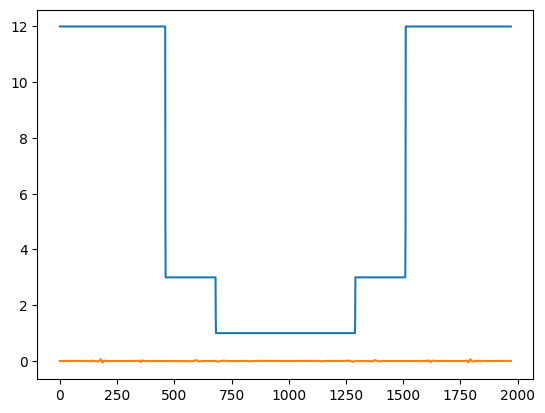

In [26]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ex_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ex)



plt.plot(eps_data)
plt.plot(ex_data)

In [27]:
modes = harminv_instance.modes[0]
modes.Q

108.13576216806091

# Example 3 : Modesolver \[[source](https://mpb.readthedocs.io/en/latest/Python_User_Interface/#the-inverse-problem-k-as-a-function-of-frequency)\]

I'll try and use the modesolver on the last problem's geometry


In [63]:
from meep.mpb import ModeSolver

eps1 = 12
eps2 = 1
grating_periodicity = 1.0
d1 = np.sqrt(eps2)/(np.sqrt(eps2) + np.sqrt(eps1))
d2 = np.sqrt(eps1)/(np.sqrt(eps2) + np.sqrt(eps1))

s1 = np.sqrt(eps1)
s2 = np.sqrt(eps2)

half_cavity_width = d2
N = 6
resolution = 21

omega = (s1 + s2)/(4*s1*s2)

pml_thickness = 1
z_center = half_cavity_width + N*grating_periodicity + pml_thickness





TypeError: ModeSolver.__init__() got an unexpected keyword argument 'epsilon_func'

In [96]:
(-71.9)%8.1

0.9999999999999911